# DNN Model:

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.callbacks import EarlyStopping
import itertools
# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Step 1: Load the JSON file with 3000 images
df = pd.read_json('C:/Users/Dell/OneDrive/Desktop/sem 3/Deep Learning/Assignment-2/photos.json', lines=True)

In [19]:
df

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food
...,...,...,...,...
200095,4Zia9NkAfQNjMfcIDhwJ-g,2HxkdqHmbYGj_BH1bLaiSw,#Nektar,food
200096,KB96KRZRhRm8hUkI-OpGEA,_gVyuTRb_6HM-SNtqbpevQ,,inside
200097,Klmojvaf2_2dP1XKzTsFmQ,NUyEOjfAl3HvkpzSpdwqeA,,food
200098,FNEiq7Mogec7t31OaU5juw,hE6YsHHV0fCz_UrGS4o6VA,Drinks by the water!,drink


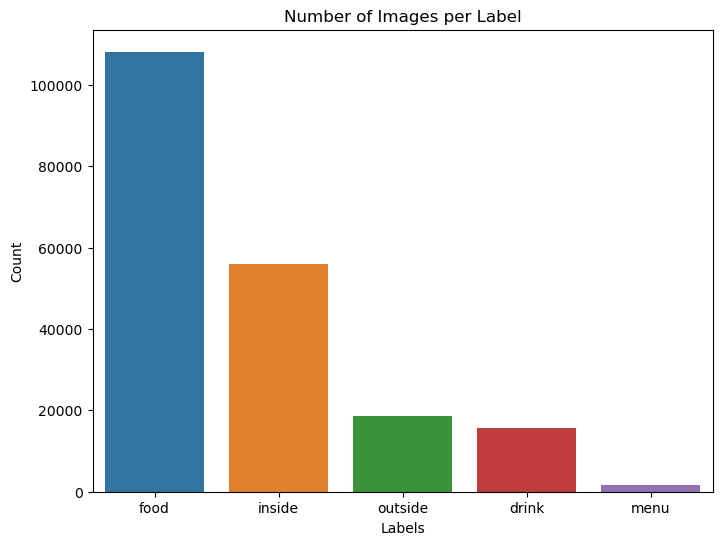

In [20]:
# Step 2: Display bar graph of number of images for each label
label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Number of Images per Label")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


In [21]:
# Step 3: Directory where images are stored
image_dir = 'C:/Users/Dell/OneDrive/Desktop/sem 3/Deep Learning/Assignment-2/photos'

# Initialize arrays for images and labels
X = []
y = []

# Map labels to integers
label_map = {'food': 0, 'inside': 1, 'outside': 2, 'drink': 3, 'menu': 4}

# Randomly sample 3000 rows from the dataframe
df_sampled = df.sample(n=3000, random_state=42)

# Load images and their corresponding labels
for idx, row in df_sampled.iterrows():
    photo_id = row['photo_id']
    label = row['label']
    
    # Create image path
    img_path = os.path.join(image_dir, f"{photo_id}.jpg")
    
    if os.path.exists(img_path):  # Ensure the image exists
        try:
            img = load_img(img_path, target_size=(128, 128))  # Resize to 128x128
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            # Append the image and label
            X.append(img_array)
            y.append(label_map[label])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    else:
        print(f"Image file {img_path} does not exist.")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images.")

Error loading image C:/Users/Dell/OneDrive/Desktop/sem 3/Deep Learning/Assignment-2/photos\1MOGQBWogR8oJr1WgERi9g.jpg: cannot identify image file <_io.BytesIO object at 0x000001B3388CB6F0>
Loaded 2999 images.


In [22]:
# Step 4: Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X.reshape(len(X), -1), y)
X_smote = X_smote.reshape(-1, 128, 128, 3)  # Reshape back to original shape


In [23]:
# Step 5: Split data into train and test sets (for evaluation after tuning)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)



In [24]:
# Step 6: Define the DNN model generator function (for hyperparameter tuning)
def create_model(optimizer='adam', neurons=128):
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [25]:
# Step 7: Hyperparameter Tuning (simplified for speed)
optimizers = ['adam']
batch_sizes = [16, 32]
epochs_list = [5, 10, 15]  # Fewer epochs for faster tuning
neuron_list = [64]  # Fix neurons to reduce tuning space

best_accuracy = 0
best_params = {}

# Early stopping to reduce training time when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Iterate through the reduced hyperparameter combinations
for optimizer, batch_size, epochs, neurons in itertools.product(optimizers, batch_sizes, epochs_list, neuron_list):
    print(f"Testing combination: Optimizer={optimizer}, Batch Size={batch_size}, Epochs={epochs}, Neurons={neurons}")
    
    # Create the model
    model = create_model(optimizer=optimizer, neurons=neurons)
    
    # Train the model with early stopping
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    
    # Evaluate the model
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    # Check if it's the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'optimizer': optimizer,
            'batch_size': batch_size,
            'epochs': epochs,
            'neurons': neurons
        }

print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.2f}")


Testing combination: Optimizer=adam, Batch Size=16, Epochs=5, Neurons=64
Testing combination: Optimizer=adam, Batch Size=16, Epochs=10, Neurons=64
Testing combination: Optimizer=adam, Batch Size=16, Epochs=15, Neurons=64
Testing combination: Optimizer=adam, Batch Size=32, Epochs=5, Neurons=64
Testing combination: Optimizer=adam, Batch Size=32, Epochs=10, Neurons=64
Testing combination: Optimizer=adam, Batch Size=32, Epochs=15, Neurons=64
Best Hyperparameters: {'optimizer': 'adam', 'batch_size': 16, 'epochs': 10, 'neurons': 64}
Best Accuracy: 0.76


In [26]:
# Step 8: Train the best model on the full training set
best_model = create_model(optimizer=best_params['optimizer'], neurons=best_params['neurons'])
history_best_model = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4205 - loss: 3.4011 - val_accuracy: 0.6023 - val_loss: 1.0842
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6586 - loss: 0.9110 - val_accuracy: 0.6887 - val_loss: 0.8047
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7452 - loss: 0.6984 - val_accuracy: 0.7789 - val_loss: 0.6084
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7965 - loss: 0.5578 - val_accuracy: 0.8256 - val_loss: 0.5150
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8023 - loss: 0.5275 - val_accuracy: 0.7346 - val_loss: 0.8289
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8184 - loss: 0.4660 - val_accuracy: 0.7015 - val_loss: 0.8983
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8420 - loss: 0.4469 - val_accuracy: 0.7692 - val_loss: 0.6911


In [27]:
# Step 9: Evaluate the final model on test data
y_pred = np.argmax(best_model.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       333
           1       0.87      0.55      0.68       323
           2       0.93      0.91      0.92       349
           3       0.68      0.86      0.76       328
           4       0.99      1.00      0.99       329

    accuracy                           0.81      1662
   macro avg       0.82      0.81      0.80      1662
weighted avg       0.82      0.81      0.81      1662



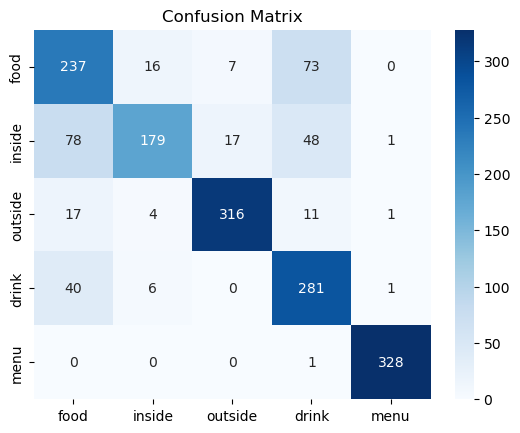

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.show()


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AUC-ROC Score: 0.96


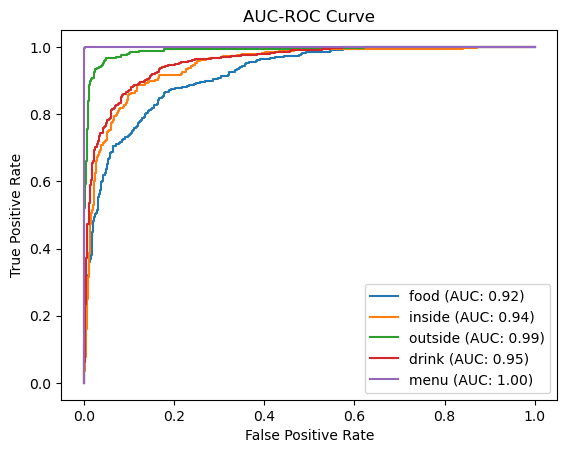

In [30]:
# AUC-ROC Curve
y_prob = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
print(f"AUC-ROC Score: {roc_auc:.2f}")

# Define class labels
class_labels = ['food', 'inside', 'outside', 'drink', 'menu']

# Plot ROC curve for each class
fpr = {}
tpr = {}
for i, label in enumerate(class_labels):  # Iterate through each class
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC: {auc(fpr[i], tpr[i]):.2f})")

plt.title("AUC-ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: 2
Predicted Probabilities: [[4.7154683e-03 6.5656839e-04 9.8533130e-01 5.5147973e-03 3.7818337e-03]]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

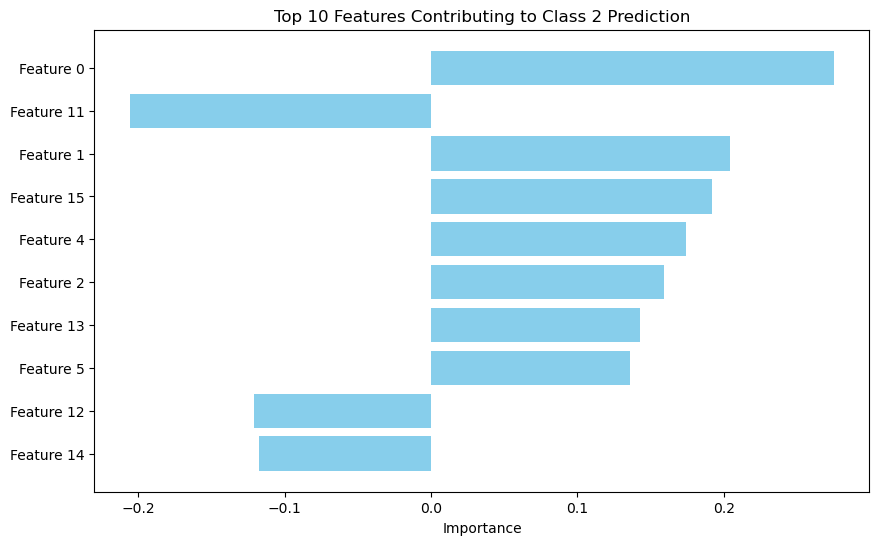

In [32]:
import matplotlib.pyplot as plt

# Step 10: LIME Interpretability
explainer = lime_image.LimeImageExplainer()

# Pick a random image from the test set for explanation
test_idx = random.randint(0, len(X_test) - 1)

# Get model predictions for the selected image
predicted_probs = best_model.predict(np.expand_dims(X_test[test_idx], axis=0))  # Expand dimensions to add batch size

# Print predicted probabilities for each class
predicted_class = np.argmax(predicted_probs)
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Probabilities: {predicted_probs}")

# Explain the image with LIME
explanation = explainer.explain_instance(
    X_test[test_idx], 
    best_model.predict, 
    top_labels=5,  # Get explanations for the top 5 labels
    hide_color=0, 
    num_samples=1000  # Number of perturbed samples
)

# Print the LIME explanation for the top class
top_class = explanation.top_labels[0]  # Get the top predicted class
print(f"LIME explanation for top predicted class: {top_class}")

# Get feature importance for the top class
lime_features = explanation.local_exp[top_class]
print(f"LIME feature importance for class {top_class}:")

# Extract features and their importance
features = [f'Feature {feature}' for feature, _ in lime_features[:10]]
importance = [importance for _, importance in lime_features[:10]]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top 10 Features Contributing to Class {top_class} Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [33]:
# Step 11: Save the final trained model
best_model.save('C:/Users/Dell/OneDrive/Desktop/sem 3/Deep Learning/DNN/photo_label_model.h5')